# This tutorial shows the calling of metacells for a scATAC-seq dataset.

In [1]:
import tempfile
import os

import subprocess
import scanpy as sc 
import datatable as dt 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import umap 

from SURE import SURE

import torch 
torch.set_float32_matmul_precision("high")


codebook_size=500 # number of metacells

/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2024-11-10 19:57:29.181423: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 19:57:29.188981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 19:57:29.201517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 19:57:29.205243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 19:57:29.214708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

## Download and load dataset

In this tutorial, we show how to call metacells by using a dataset including data produced by scATAC-seq. The dataset could be downloaded from the CellxGene website [here](https://cellxgene.cziscience.com/collections/d36ca85c-3e8b-444c-ba3e-a645040c6185). 

In [2]:
adata = sc.read_h5ad('/media/oem/UB20_DATA/Workspace/Tutorial/tutorial_13/b0715f5e-4b34-48f0-aa15-8c366b6f6011.h5ad')
adata = adata.raw.to_adata()
adata.layers['counts'] = adata.X.copy()

## Use SURE to call metacells within this dataset

### Prepare the input files and run SURE's shell command

In [3]:
with tempfile.TemporaryDirectory() as temp_dir:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=True)

    # write count data into a local file
    xs = adata.layers['counts'].toarray()
    counts_file = os.path.join(temp_dir, 'temp_counts.txt.gz')
    dt.Frame(pd.DataFrame(xs, columns=adata.var_names, dtype=np.float64)).to_csv(counts_file)

    # write undesired factors into a local file
    enc = OneHotEncoder(sparse_output=False).fit(adata.obs['sample_uuid'].to_numpy().reshape(-1,1))
    us = enc.transform(adata.obs['sample_uuid'].to_numpy().reshape(-1,1))
    uwv_file = os.path.join(temp_dir, 'temp_uwv.txt.gz')
    pd.DataFrame(us, columns=enc.categories_).to_csv(uwv_file, index=False)

    # call SURE
    model_file = os.path.join(temp_dir, f'temp_sure_{codebook_size}.txt.gz')
    cmd = f'CUDA_VISIBLE_DEVICES=0  SURE --data-file "{counts_file}" \
    --undesired-factor-file "{uwv_file}" \
    --jit \
    --seed 0 \
    --cuda \
    -lr 0.0001 \
    -n 200 \
    -bs 1000 \
    -cs {codebook_size} \
    -dirichlet \
    -likeli negbinomial \
    -zi exact \
    --save-model "{model_file}"'

    subprocess.call(cmd, shell=True)

    # load the model
    model = SURE.load_model(model_file)

100%|██████████| 40/40 [00:00<00:00, 144.21batch/s]


Model saved to /tmp/tmpmx6phjmi/temp_sure_500.txt.gz
Model loaded from /tmp/tmpmx6phjmi/temp_sure_500.txt.gz


### Get the latent representations of cells

In [4]:
zs = model.get_cell_coordinates(xs)

umap_model = umap.UMAP().fit(zs)
adata.obsm['X_umap'] = umap_model.transform(zs)

100%|██████████| 40/40 [00:00<00:00, 318.41batch/s]


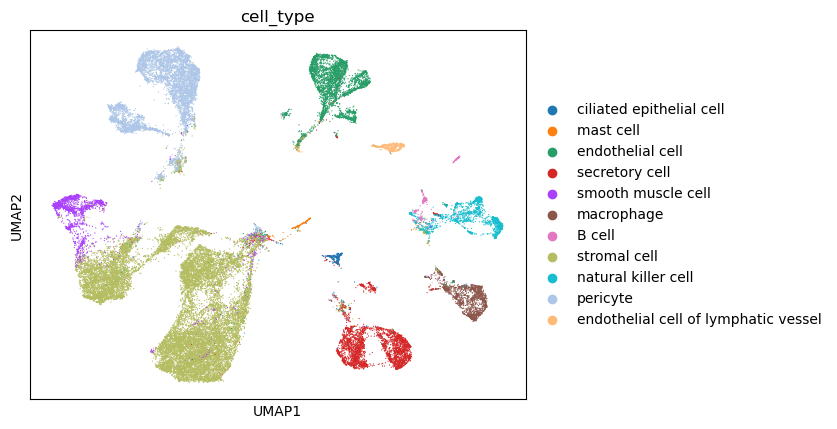

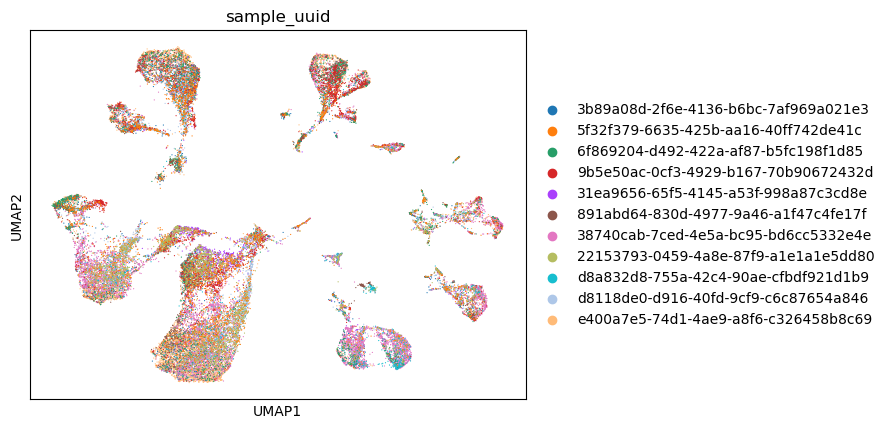

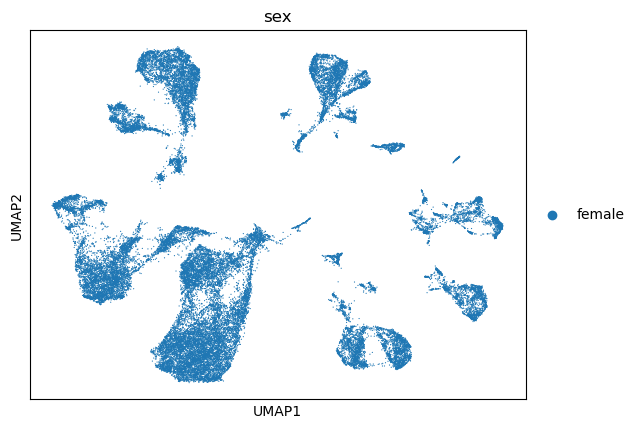

In [5]:
sc.pl.umap(adata, color='cell_type')
sc.pl.umap(adata, color='sample_uuid')
sc.pl.umap(adata, color='sex')

### Get metacells

In [6]:
zs_metacells = model.get_metacell_coordinates()
umap_metacells = umap_model.transform(zs_metacells)

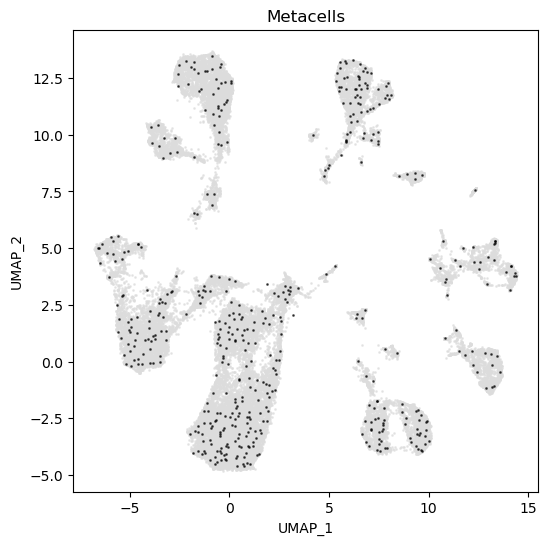

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))  # Set the figure size
plt.scatter(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1], s=1, c='gainsboro', alpha=0.6)
plt.scatter(umap_metacells[:,0], umap_metacells[:,1], s=1, c='black', alpha=0.6)


# Add labels and title
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.title('Metacells')

# Show the plot
plt.show()